+ 代码slide：https://courses.d2l.ai/zh-v2/assets/notebooks/chapter_convolutional-modern/batch-norm.slides.html#/
+ 视频地址： https://www.bilibili.com/video/BV1X44y1r77r?p=2

# 从0实现

+ 想实现batch_normalization这个层，首先要实现batch_norm这个操作，也就是那个公式计算
+ 类似当时实现卷积层的时候，先实现了二维互相关运算，再去实现卷积层

In [1]:
import torch
from torch import nn
import d2l_torch as d2l

## batch_norm运算定义

实现batch_norm计算

+ github的issue：[Acquiring "is_grad_enabled()" inside an autograd function #56370](https://github.com/pytorch/pytorch/issues/56370)
+ pytorch文档：[TORCH.IS_GRAD_ENABLED](https://pytorch.org/docs/stable/generated/torch.is_grad_enabled.html?highlight=is_grad_enabled)
> Returns True if grad mode is currently enabled.   返回当前求导模式是否可用。

----
另外，搜索过程中发现更常见的一个语句是：`torch.set_grad_enabled(False)`
参考：[torch.set_grad_enabled(False)](https://blog.csdn.net/qq_40840797/article/details/119734575)
+ volatile是用来在验证或者测试的时候将输入设置成volatile，这样后继几点全部都被设置成volatile，也就是不需要自动求导。
+ 0.4.0以后采用torch.set_grad_enabled()来替代这种用法
+ 但是torch.set_grad_enabled()在使用的时候是设置一个上下文环境，也就是说只要设置了torch.set_grad_enabled(False)那么接下来所有的tensor运算产生的新的节点都是不可求导的，这个相当于一个全局的环境，即使是多个循环或者是在函数内设置的调用，只要torch.set_grad_enabled(False)出现，则不管是在下一个循环里还是在主函数中，都不再求导，除非单独设置一个孤立节点，并把他的requires_grad设置成true。


In [2]:
def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    """
    X:
    输入的数据（比如全连接层输出的，relu层之前）
    gamma和beta：
    就是可以学习的那两个超参数
    moving_mean和moving_var
    就是随机偏移和随机缩放，可以认为这是全局的均值和方差，是做推理的时候用的。
    可以认为是整个数据集上的均值和方差，而不是某个mini_batch上的均值和方差
    eps，
    就是为了防止方差为0，防止出现除0错误。如果不加这个简单的东西，可能一切都不同了
    一般也有个固定的值（轻易不要去修改）
    momentum
    是用来更新moving_mean和moving_var的一个东西，通常取0.9或者固定的一个东西
    
    """
    # 推理模式
    if not torch.is_grad_enabled(): # 如果梯度计算不可用（也就是推理模式）
        X_hat=(X-moving_mean)/torch.sqrt(moving_var+eps)  
    
    # 训练模式
    else:
        assert len(X.shape) in (2,4) 
        if len(X.shape)==2:  # 对于全连接层来说，作用在特征维
            mean=X.mean(dim=0) # 按照行求均值  全连接层的BN作用在特征维上  最终得到一个1xn的行向量， n表示全连接层输入数据的特征数
            var=((X-mean)**2).mean(dim=0)   # 方差=(每个样本-均值)的平方和，再除以样本数，看下面的公式。其实把求和和除以样本数这步，直接用mean方法代替了
        
        else: # 对于卷积层来说，作用在通道维度(也就是把所有通道对应位置加起来，求平均，得到的应该是 1x通道的高x通道的宽 这么一个矩阵 )
            mean=X.mean(dim=(0,2,3),keepdim=True) # 这里最终得到的就是 1xnx1x1的一个4d的结果，n表示输入/输出通道数
            var=((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
           
        X_hat=(X-mean)/torch.sqrt(var+eps)    # 这里X-mean的时候其实已经使用了广播机制了！！！！👍🤓
        moving_mean=momentum*moving_mean+(1-momentum)*mean  
        # 从指数加权平均来看，这里其实就是使用上一时刻的moving_mean的加权，与整个数据集上的mean的加权，作为下一次moving_mean的预测值
        moving_var=momentum*moving_var+(1-momentum)*var
    Y=gamma*X+beta
    return Y,moving_mean.data,moving_var.data  # return moving_mean和var其实是因为推理阶段要直接使用这个计算出的方差和均值

验证全连接层的计算

推理：
+ 推理的时候，对输入数据的BN处理，其实是使用了全局的均值和方差
+ 因为推理的时候，可能X就只是一个样本，一个batch就是一个样本，那么这个时候如果还使用batch的话 就没法计算了，所以使用全局的均值和方差
+ 推理的时候，使用的全局的均值和方差其实来源于预测集的均值和方差（实际推理的时候，也默认新的数据和预测集分布一致，也可以使用预测集的均值和方差）

训练：
+ 首先判断是全连接层还是卷积层（只会作用在这两种层上，其它层不适用/没有写对应的处理函数），这里只设计了2d的卷积，其他1d和3d的不支持
    + 全连接层的输入维度是：batch_size，每个样本的维度（一维向量），比如：(32,64)表示每个样本是64维，每批是32个样本
    + 卷积层的输入维度是：(batch_size,输入通道数，高，宽)
+ 如果对axis或者dim有疑惑的话，可以去复习一下之前写的总结，[numpy中关于数组维度的理解——dim和axis](https://blog.csdn.net/Castlehe/article/details/116022827)

均值和方差计算公式：
+ 参考百度百科，点击[这里](https://baike.baidu.com/item/%E6%96%B9%E5%B7%AE%E8%AE%A1%E7%AE%97%E5%85%AC%E5%BC%8F/5318566?fr=aladdin)

平均值的计算公式为：
$$M=\frac{x_1+x_2+x_3+...+x_n}{n}$$

方差的计算公式为：
$$s^2=\frac{(x_1-M)^2+(x_2-M)^2+(x_3-M)^2+...+(x_n-M)^2}{n}$$

In [5]:
X=torch.rand((10,2))  # 创建10个样本，每个样本的特征数是2维
print(X)
mean=X.mean(dim=0)
print(mean)   #按照列求均值，最终得到各列特征的均值
print(((X-mean)**2).mean(dim=0))  
# (X-mean)**2 这个的维度其实和x一样，
# 所以后面的mean(dim=0)和求均值得到的结果维度也是一样的。  
# 都求的是某列特征的统计指标（均值/方差）

tensor([[0.2182, 0.9085],
        [0.3319, 0.3531],
        [0.3642, 0.6632],
        [0.3902, 0.5621],
        [0.3267, 0.0696],
        [0.1570, 0.3461],
        [0.4564, 1.0000],
        [0.5459, 0.1419],
        [0.0855, 0.2092],
        [0.5688, 0.2629]])
tensor([0.3445, 0.4517])
tensor([0.0224, 0.0924])


验证卷积层的计算

In [13]:
X=torch.rand((2,3,2,3)) # 两个三通道的，图像高为2，宽为3的输入
print(X)
mean=X.mean(dim=(0,2,3),keepdim=True)
print(mean,"\n",mean.shape)

tensor([[[[0.3377, 0.0040, 0.1068],
          [0.8988, 0.8476, 0.4406]],

         [[0.2373, 0.8555, 0.5407],
          [0.0875, 0.8951, 0.0701]],

         [[0.9436, 0.8168, 0.6496],
          [0.9063, 0.3542, 0.3073]]],


        [[[0.5269, 0.7035, 0.4117],
          [0.2906, 0.5506, 0.3359]],

         [[0.9111, 0.6993, 0.8829],
          [0.9526, 0.2769, 0.9301]],

         [[0.2550, 0.0682, 0.5667],
          [0.2577, 0.5471, 0.3435]]]])
tensor([[[[0.4546]],

         [[0.6116]],

         [[0.5013]]]]) 
 torch.Size([1, 3, 1, 1])


相当于先把所有batch加一起，然后把每个通道的高加起来，把通道的宽加起来，所有batch的所有通道最后就变成了 一个batch的通道数，比如上面的例子中，最终结果就是通道数个数字。 相当于对所有通道进行mean

逐步拆解一下，X.mean(dim=(0,2,3),keepdim=True)

In [11]:
dim_0_mean=X.mean(dim=0,keepdim=True)
print(f"dim=0的mean结果：\n{dim_0_mean}")  # 也可以把keepdim去掉看看 就是多一层括号而已，不影响什么


dim_0_2_mean=X.mean(dim=(0,2),keepdim=True)
dim_02_mean=dim_0_mean.mean(dim=(2),keepdim=True)
print(f"dim=(0,2)的mean结果：\n{dim_0_2_mean}")
print(f"对dim_0_mean进行dim=(2)的mean结果：\n{dim_02_mean}")  # 可以看到，结果是一样的，所以就是逐步对每个axis进行mean

dim=0的mean结果：
tensor([[[[0.3743, 0.6863, 0.5956],
          [0.7442, 0.5927, 0.2910]],

         [[0.5139, 0.9126, 0.3580],
          [0.8266, 0.9070, 0.7208]],

         [[0.7736, 0.8704, 0.1138],
          [0.3995, 0.3889, 0.5261]]]])
dim=(0,2)的mean结果：
tensor([[[[0.5593, 0.6395, 0.4433]],

         [[0.6703, 0.9098, 0.5394]],

         [[0.5865, 0.6297, 0.3200]]]])
对dim_0_mean进行dim=(2)的mean结果：
tensor([[[[0.5593, 0.6395, 0.4433]],

         [[0.6703, 0.9098, 0.5394]],

         [[0.5865, 0.6297, 0.3200]]]])


## BatchNorm层

有了batchnorm运算之后，就可以去定义batchnorm层了

In [4]:
class BatchNorm(nn.Module):
    def __init__(self,num_features,num_dims):
        """
        这里的num_features，要么就是作用于特征维度，要么就是作用于通道维度。
        取决于后面的num_dims，num_dims只有两种取值，2（全连接层）和4（卷积层)
        """
        super().__init__()
        if num_dims==2:
            shape=(1,num_features)
        else:
            shape=(1,num_features,1,1)
        # 定义num_features就是因为这个输出shape会被用在一些变量的初始化中，Y=gamma*X+beta  
        # 为了确保可以使用广播机制，所以这个shape尽量要和输入X接近，可以进行乘法运算等🤗🤐🤐
        self.gamma=nn.Parameter(torch.ones(shape))   #这里没有使用0初始化，因为直接用0的话，根据计算公式，就没了，全部为0了
        self.beta=nn.Parameter(torch.zeros(shape))   # 这个是加法，就可以直接用0初始化
        self.moving_var=torch.ones(shape)
        self.moving_mean=torch.zeros(shape)
        
    def forward(self,X):
        # 由于moving这两个参数不在Parameter里，所以不一定会和网络模型的device一样，所以要检查下，如果不一样，就移过去
        if self.moving_mean.device!=X.device:
            self.moving_mean=self.moving_mean.to(X.device)
            self.moving_var=self.moving_var.to(X.device)
        Y,self.moving_mean,self.moving_var=batch_norm(
            X,self.gamma,self.beta,self.moving_mean,self.moving_var,eps=1e-5,momentum=0.9) 
        # ❗ eps不同框架设置的默认值不一样，这个在迁移的时候要注意
        return Y    

## 将BatchNorm层用于LeNet网络

+ 对于卷积层来说，作用在通道上，所以那个num_features就是通道数，num_dims=4
+ 如果是放在卷积层和全连接层的后面，激活函数的前面，那么num_features就是输出通道/全连接层输出 的维度
+ 相当于对Lenet中除最后一层全连接层以外的所有卷积层和全连接层都加入了BN
    + 最后的全连接层不用加BN层是因为没必要，没必要进行一个线性变换。因为softmax用了之后都会被normalize掉的

In [15]:
net_mine=torch.nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2), BatchNorm(num_features=6,num_dims=4),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),BatchNorm(num_features=16,num_dims=4),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*5*5,120),BatchNorm(num_features=120,num_dims=2),nn.Sigmoid(),
    nn.Linear(120,84),BatchNorm(num_features=84,num_dims=2),nn.Sigmoid(),
    nn.Linear(84,10))  

loss 0.375, train acc 0.860, test acc 0.839
24604.6 examples/sec on cuda:0


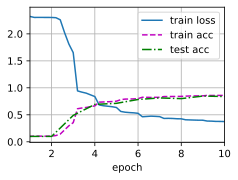

In [18]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net_mine, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

没有加BN的lenet
```bash
loss 0.471, train acc 0.822, test acc 0.801 
20190.2 examples/sec on cuda:0 
```
加了BN的Lenet
```bash
loss 0.375, train acc 0.860, test acc 0.839
24604.6 examples/sec on cuda:0
```

所以确实可以看到，加了BN效果更好了，我的加了BN反倒速度变快了。。。。收敛加快没不确定，但是计算速度竟然变快了。。

In [13]:
net_teacher = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),nn.Sigmoid(), 
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16,kernel_size=5), BatchNorm(16, num_dims=4),nn.Sigmoid(), 
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(16 * 4 * 4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2),nn.Sigmoid(), 
    nn.Linear(84, 10))

loss 0.359, train acc 0.866, test acc 0.860
17890.2 examples/sec on cuda:0


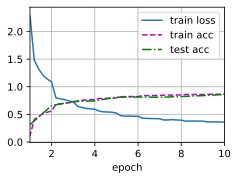

In [17]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net_teacher, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

其实老师课上讲的这个加了BN的lenet和之前讲的lenet有点出入，但是仅仅是因为第一个卷积层不加padding导致的，对于这个有一点点出入的网络，其计算结果如下

没有加BN的lenet（之前在mac上跑的）
```bash
loss 0.471, train acc 0.822, test acc 0.801 
20190.2 examples/sec on cuda:0 
```

没有加BN的lenet（和下面相同环境）
```bash
loss 0.470, train acc 0.822, test acc 0.787
36645.0 examples/sec on cuda:0

```

加了BN的Lenet
```bash
loss 0.367, train acc 0.864, test acc 0.828
31371.3 examples/sec on cuda:0
```
 
+ 所以计算速度其实减慢了，但是在同样训练epoch次数的情况下，加了BN之后，相同时间内，得到的精度更高，其实就说明加速收敛了。
    + 其实让没有BN的lenet多跑几轮，应该也可以达到上面那个精度，实验一下，这其实就说明BN可以加快收敛
    + **这里学习率从0.9变成了1.0，但是加大学习率依然可以保证收敛**
    + 其实2.0的学习率也可以试试

❗❗❗
另外，在加快收敛的这个事情上，有个小问题
+ 计算量变大了，其实每个epoch的计算会比之前慢一点
+ 但是相比于多几个epoch整体的时间，加了BN之后每个epoch多的那点计算的时间，其实远小于不加BN多几个完整的epoch的时间

## BN放在激活函数之后

In [15]:
net_teacher_after = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.Sigmoid(), BatchNorm(6, num_dims=4),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16,kernel_size=5), nn.Sigmoid(), BatchNorm(16, num_dims=4),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(16 * 4 * 4, 120), nn.Sigmoid(),BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(), BatchNorm(84, num_dims=2),
    nn.Linear(84, 10))

loss nan, train acc 0.100, test acc 0.100
15036.1 examples/sec on cuda:0


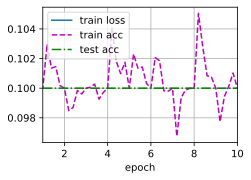

In [18]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net_teacher_after, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 学习到的gamma和beta

看一下第一个卷积层后面那个BN层学到的参数——拉伸参数`gamma`和偏移参数`beta`

In [28]:
net_teacher[1].gamma.reshape((-1)),net_teacher[1].beta.reshape((-1))
# 6个通道，所以gamma和beta都是(1,6,1,1)的维度

(tensor([1.7498, 2.5842, 3.5742, 1.7751, 2.3698, 4.2053], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-0.7567, -0.7558, -0.0323, -1.5920, -0.5196,  0.2161], device='cuda:0',
        grad_fn=<ViewBackward>))

In [30]:
print("第一个卷积层后面的BN层计算出的moving_mean和moving_var分别为")
net_teacher[1].moving_mean.reshape((-1)),net_teacher[1].moving_var.reshape((-1))

第一个卷积层后面的BN层计算出的moving_mean和moving_var分别为


(tensor([-0.4292, -0.5746, -2.9190, -0.6753, -0.6022, -6.0405], device='cuda:0'),
 tensor([ 1.0872,  1.2776,  7.3713,  1.8341,  2.6799, 30.2981], device='cuda:0'))

In [31]:
print("倒数第二个全连接层后面的BN计算出的moving_mean和moving_var分别为")
net_teacher[13].moving_mean.reshape((-1)),net_teacher[13].moving_var.reshape((-1))

倒数第二个全连接层后面的BN计算出的moving_mean和moving_var分别为


(tensor([-1.4664, -1.4212, -1.5986, -1.9724, -1.7622, -2.2732, -1.7621, -1.7081,
         -2.3332, -1.5817, -1.0769, -1.4297, -1.3896, -2.5994, -0.1182, -0.7955,
         -2.2623, -1.5461, -1.5919, -2.5229, -2.0010, -1.0900, -1.4767, -1.3604,
         -1.5155, -0.2287, -1.5478, -1.3014, -1.2464, -1.7488, -1.8901, -1.7243,
         -1.5069,  0.0750, -0.2063, -0.8212, -1.8053, -0.8211, -1.6383, -2.0199,
         -1.8555, -0.8858, -0.7051, -1.8204, -1.3633, -1.4073, -1.0788, -1.8355,
         -1.1473, -1.3497,  1.8903, -1.2790, -1.8015, -1.2761, -1.7770, -1.4930,
         -1.2606, -0.5721, -1.4529, -0.8748, -2.0754, -1.8785, -1.5440, -1.9344,
         -1.6886, -1.7155, -1.6098, -1.1079,  0.1177, -1.3248, -1.7116, -1.4397,
         -1.5096, -1.5785, -1.0831, -1.6369, -1.9434, -1.2586, -1.6151, -1.4307,
         -1.9019, -1.6514, -2.5849, -2.7418], device='cuda:0'),
 tensor([4.8628, 1.4068, 0.2204, 2.5411, 3.1509, 5.8994, 0.6599, 1.8060, 1.4078,
         1.8027, 5.1548, 0.5061, 1.1494, 1.44

维度都那不一样，没办法比较。。。

In [32]:
net_teacher[1].moving_mean.reshape((-1)).mean(),net_teacher[1].moving_var.reshape((-1)).mean()

(tensor(-1.8735, device='cuda:0'), tensor(7.4247, device='cuda:0'))

In [33]:
net_teacher[13].moving_mean.reshape((-1)).mean(),net_teacher[13].moving_var.reshape((-1)).mean()

(tensor(-1.4438, device='cuda:0'), tensor(2.1424, device='cuda:0'))

均值看起来确实有点相近。。？？？ 可能是我计算方式有问题

## 指数加权平均说明

+ 指数加权平均(exponentially weighted averges)也叫指数加权移动平均，通过它可以来计算局部的平均值，来描述数值的变化趋势
+ 指各数值的加权系数随时间呈指数式递减，越靠近当前时刻的数值加权系数就越大。

参考：
+ [指数加权移动平均法（EWMA）](https://www.cnblogs.com/jiangxinyang/p/9705198.html指数加权移动平均法（EWMA）)
+ [优化算法之指数加权平均详解](https://blog.csdn.net/sinat_29957455/article/details/81175894)

最直观的一个例子是，通过温度的局部平均值(移动平均值)来描述温度的变化趋势

$$v_t=\beta*v_{t-1}+(1-\beta)*\theta_t$$

+ 其中$\theta$表示当天的温度，$v$表示局部平均值。
+ 等号右边用前一时刻的局部温度的加权，与当天整体温度的加权，来共同描述等号左边下一时刻的温度
+ EWMA 主要是被应用在动量优化算法中，比如Adam算法中的一阶矩和二阶矩都采用了上面修改后的EWMA算法。

## 广播机制

+ `X_hat=(X-mean)/torch.sqrt(var+eps)  ` 这里其实使用了广播机制
+ 另外，在batchnorm层中，`self.gamma=nn.Parameter(torch.ones(shape)) `这里的shape，其实也是为了可以进行广播机制才这样的
    + (m,n)和(1,n)可以广播，(m,n)和(m,)是不能广播的。。。❓❓❓  可以试试

In [10]:
a=torch.rand((3,4))
b=torch.rand((1,4))
print(f"a={a}\nb={b}\na*b={a*b}")

c=torch.rand((3,1))  
print(f"a={a}\nc={c}\na*c={a*c}")

c2=torch.rand((3,))  
# non-singleton).  Spring之前为bean提供了两种作用域：单例和原型(或者叫非单例)。
print(f"a={a}\nc={c2}\na*c2={a*c2}")

a=tensor([[0.3973, 0.4619, 0.7873, 0.9544],
        [0.8540, 0.0175, 0.9518, 0.6392],
        [0.6380, 0.2578, 0.7196, 0.2721]])
b=tensor([[0.8034, 0.5830, 0.5560, 0.3730]])
a*b=tensor([[0.3192, 0.2693, 0.4378, 0.3560],
        [0.6861, 0.0102, 0.5292, 0.2384],
        [0.5126, 0.1503, 0.4001, 0.1015]])
a=tensor([[0.3973, 0.4619, 0.7873, 0.9544],
        [0.8540, 0.0175, 0.9518, 0.6392],
        [0.6380, 0.2578, 0.7196, 0.2721]])
c=tensor([[0.2452],
        [0.2426],
        [0.5785]])
a*c=tensor([[0.0974, 0.1132, 0.1930, 0.2340],
        [0.2071, 0.0042, 0.2309, 0.1550],
        [0.3691, 0.1492, 0.4163, 0.1574]])


RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 1

即如果想采取广播，那么不能使用这种维度不确定的（待推理的），必须是明确的维度参数

# 简洁实现

直接调包实现很简单，1d就是全连接层，2d就是2d卷积层

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),nn.Sigmoid(), 
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(256, 120), nn.BatchNorm1d(120),nn.Sigmoid(), 
    nn.Linear(120, 84), nn.BatchNorm1d(84),nn.Sigmoid(), 
    nn.Linear(84, 10))

loss 0.246, train acc 0.910, test acc 0.839
33453.6 examples/sec on cuda:0


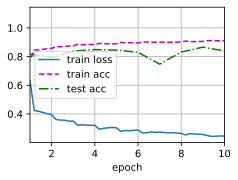

In [35]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

```bash
loss 0.367, train acc 0.864, test acc 0.828
31371.3 examples/sec on cuda:0
```

相比于之前从0实现，这个简洁实现感觉更好一点。。（计算快，应该是有优化）

In [8]:
net_after = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.Sigmoid(), nn.BatchNorm2d(6),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),nn.Sigmoid(), nn.BatchNorm2d(16), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(256, 120), nn.Sigmoid(), nn.BatchNorm1d(120),
    nn.Linear(120, 84), nn.Sigmoid(), nn.BatchNorm1d(84),
    nn.Linear(84, 10))

loss 0.281, train acc 0.894, test acc 0.880
23789.7 examples/sec on cuda:0


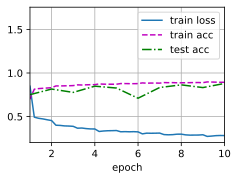

In [9]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net_after, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 其他验证

In [4]:
import torch
from torch import nn

m = nn.BatchNorm2d(10)
# Without Learnable Parameters
n = nn.BatchNorm2d(10, affine=False)

input_data = torch.randn(20, 10, 5, 5)

output = m(input_data)
print(f"原始值为：{input_data[1][1]}，\nBN作用之后的值为：{output[1][1]}")

output = n(input_data)
print(f"原始值为：{input_data[1][1]}，\nBN(affine=False)作用之后的值为：{output[1][1]}")

原始值为：tensor([[-1.1158, -0.3184,  0.2714, -0.2995, -0.3221],
        [ 0.3102, -0.4627,  1.0819, -0.6453, -0.7787],
        [ 0.6987,  0.1864, -0.5483,  1.4827,  2.2548],
        [ 0.2655, -0.0697, -0.0276,  0.6201,  0.3225],
        [ 0.3536,  1.8600,  0.4018, -0.7466,  0.2480]])，
BN作用之后的值为：tensor([[-1.0572e+00, -2.8132e-01,  2.9265e-01, -2.6289e-01, -2.8492e-01],
        [ 3.3036e-01, -4.2170e-01,  1.0813e+00, -5.9934e-01, -7.2915e-01],
        [ 7.0848e-01,  2.0993e-01, -5.0498e-01,  1.4714e+00,  2.2226e+00],
        [ 2.8695e-01, -3.9237e-02,  1.7145e-03,  6.3192e-01,  3.4239e-01],
        [ 3.7266e-01,  1.8385e+00,  4.1957e-01, -6.9795e-01,  2.6991e-01]],
       grad_fn=<SelectBackward>)
原始值为：tensor([[-1.1158, -0.3184,  0.2714, -0.2995, -0.3221],
        [ 0.3102, -0.4627,  1.0819, -0.6453, -0.7787],
        [ 0.6987,  0.1864, -0.5483,  1.4827,  2.2548],
        [ 0.2655, -0.0697, -0.0276,  0.6201,  0.3225],
        [ 0.3536,  1.8600,  0.4018, -0.7466,  0.2480]])，
BN(affine=False)作

+ 没有训练起来，所以看不出区别
+ 不管affine取值如何，上面网络都只有初始化，所以值都是一样的